# This has only one purpose - show how the rise time changes with signal amplitude

In [1]:
%run readCa45.py

Inverse of the electronics

In [2]:
@jit(nopython=True)
def rc2_cr(wf, fallTime):
    wf2 = np.empty(3500)
    length = len(wf2)
    wf -= np.mean(wf[:400])
    wf /= np.amax(wf)
    
    alpha_cr = fallTime/(fallTime+1.); #fall time of output
    alpha_rc1 = 1./2.75;
    alpha_rc2 = 1./2.75;    
    zrc1 = np.zeros(2)
    zcr = np.zeros(2)
    zcharge = np.zeros(2)
    zrc2 = wf[:2].copy()
    for i in range(length):
        zrc2[i%2] = wf[i]
        
        zrc1[i%2] = (zrc2[i%2] - zrc2[(i+1)%2])/alpha_rc2 + zrc2[(i+1)%2]
        zcr[i%2] = (zrc1[i%2] - zrc1[(i+1)%2])/alpha_rc1 + zrc1[(i+1)%2]
        zcharge[i%2] = (zcr[i%2]/alpha_cr) - zcr[(i+1)%2] + zcharge[(i+1)%2] 

        wf2[i] = zcharge[i%2]
    
    return wf2

Lookup table of the detector attributes

In [3]:
# fall_times[board][channel] 
fall_times=[[1000, 1031.3367, 1086.8575, 1217.0291, 1041.5563, 1000,      1230.2096, 1188.8999],\
            [1000, 1263.1642, 1233.1743, 999.1461,  1199.1291, 1112.0769, 1049.4534, 1219.0482],\
            [1000, 1000,      1077.4932, 1157.1627, 1000,      1163.2235, 1000,      1000],\
            [1000, 1027.103,  1111.1212, 1033.5468, 1109.469,  1022.693,  1929.7336, 1000],\
            [1000, 1124.478,  1073.1306, 1007.7979, 1100.4457, 1045.0566, 1135.8975, 1073.1854],\
            [1000, 1000,      1087.187,  1133.1069, 1005.3494, 1000,      1000,      1000]]

# lookup table as described in image
pixel_to_bc = { '39W':(0,1),'62W':(1,1),'77W':(2,1),'39E':(3,1),'62E':(4,1),'77E':(5,1), \
                '40W':(0,2),'63W':(1,2),'78W':(2,2),'40E':(3,2),'63E':(4,2),'78E':(5,2), \
                '41W':(0,3),'64W':(1,3),'87W':(2,3),'41E':(3,3),'64E':(4,3),'87E':(5,3), \
                '50W':(0,4),'65W':(1,4),'88W':(2,4),'50E':(3,4),'65E':(4,4),'88E':(5,4), \
                '51W':(0,5),'66W':(1,5),'89W':(2,5),'51E':(3,5),'66E':(4,5),'89E':(5,5), \
                '52W':(0,6),'75W':(1,6),            '52E':(3,6),'75E':(4,6),       \
                '53W':(0,7),'76W':(1,7),            '53E':(3,7),'76E':(4,7) }

# put it all together to look up fall time
def fallTimeLookup(pixel):
    if (pixel not in pixel_to_bc):
        print('Could not find pixel '+pixel+' in lookup table')
        return None
    board, channel = pixel_to_bc[pixel]
    return fall_times[board][channel]

In [4]:
import h5py

In [5]:
EnergyBins = np.linspace(0,6000,61)

In [6]:
AVG_WF = np.zeros((len(EnergyBins)+1, 3500))

In [7]:
WF_COUNT = np.zeros(len(EnergyBins)+1)

In [8]:
EnergyBins

array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
        900., 1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700.,
       1800., 1900., 2000., 2100., 2200., 2300., 2400., 2500., 2600.,
       2700., 2800., 2900., 3000., 3100., 3200., 3300., 3400., 3500.,
       3600., 3700., 3800., 3900., 4000., 4100., 4200., 4300., 4400.,
       4500., 4600., 4700., 4800., 4900., 5000., 5100., 5200., 5300.,
       5400., 5500., 5600., 5700., 5800., 5900., 6000.])

## Parse through the data, undoing the electronics, normalizing, and putting in an appropriate energy bin

In [13]:
for fileName in os.listdir('.'):
    if fileName[-4:]=='hdf5':
        f = h5py.File(fileName, 'r')
        for i in range(10**4): #len(f['X'])):
            rc_pulse = rc2_cr(f['X'][i], fallTimeLookup((f['pixelIDs'][i]).decode('utf-8')))
            E_id = int(f['E'][i]/100)-1
            if E_id > len(AVG_WF)-1:
                E_id = len(AVG_WF) - 1
            AVG_WF[E_id] += rc_pulse
            WF_COUNT[E_id] += 1
        f.close()

In [14]:
WF_COUNT

array([1.495e+03, 1.572e+03, 1.421e+03, 1.140e+03, 9.390e+02, 8.120e+02,
       5.850e+02, 4.950e+02, 4.300e+02, 3.410e+02, 2.030e+02, 1.540e+02,
       8.000e+01, 4.800e+01, 2.000e+01, 6.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 4.500e+01, 1.400e+01, 0.000e+00, 0.000e+00,
       0.000e+00, 1.000e+00, 1.000e+00, 8.000e+00, 1.900e+01, 1.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 1.680e+02])

In [15]:
AVG_WF /= WF_COUNT.reshape(-1,1)

/home/david/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


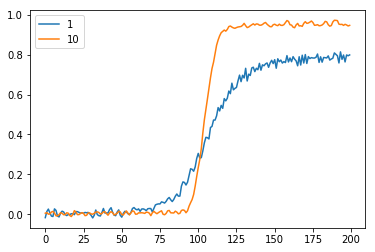

In [16]:
plot(AVG_WF[1][900:1100], label='1')
plot(AVG_WF[10][900:1100], label='10')
legend();
savefig('holyHauntedRiseTimesBatman.png')

# This is the plot that shows it! 
You can see that at the lower energy the signal takes much longer to reach its maximum value